# Báo Cáo Data Science: Dự báo Tiến Độ Học Tập (Learning Progress Prediction)

Mục tiêu notebook: trình bày đầy đủ quy trình của một Data Scientist từ EDA → làm sạch → trích xuất đặc trưng → huấn luyện → giải thích kết quả → tạo submission, với comment tiếng Việt rõ ràng, ưu tiên logic nghiệp vụ và tránh rườm rà mã nguồn.

# 1) Import Thư Viện & Cấu Hình Đường Dẫn

Trong phần này, ta import các thư viện cần thiết và thiết lập cấu hình chung (seed, đường dẫn dữ liệu, cấu hình hiển thị).

In [ ]:
# Import thư viện cần thiết và cấu hình chung
# Lưu ý: comment tiếng Việt chi tiết để người đọc hiểu mục đích từng bước
import shap
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Thiết lập seed để tái lập kết quả
SEED = 42
np.random.seed(SEED)

DATA_DIR = "data"
ADM_PATH = os.path.join(DATA_DIR, "admission.csv")
REC_PATH = os.path.join(DATA_DIR, "academic_records.csv")
TEST_PATH = os.path.join(DATA_DIR, "test.csv")

# Hiển thị pandas gọn gàng
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)


c:\Users\levie\Downloads\DF\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Đã cấu hình xong import và đường dẫn dữ liệu.


# 2) Đọc Dữ Liệu & Chuẩn Hóa Mốc Thời Gian Học Kỳ

Trong phần này, ta đọc 3 file dữ liệu và chuẩn hóa cột `HOC_KY` về `(year_start, semester_num)`,
sau đó tạo `semester_index` theo từng sinh viên để đảm bảo thứ tự thời gian.

In [3]:
# Đọc dữ liệu và chuẩn hóa thời gian
from utils import parse_hoc_ky  # tái sử dụng hàm từ utils để đồng nhất với pipeline script

# Đọc dữ liệu CSV
admission = pd.read_csv(ADM_PATH)
records = pd.read_csv(REC_PATH)
test = pd.read_csv(TEST_PATH)

# Parse HOC_KY thành (year_start, semester_num) và tạo semester_index
records[["year_start", "semester_num"]] = records["HOC_KY"].apply(parse_hoc_ky).apply(pd.Series)
records = records.sort_values(["MA_SO_SV", "year_start", "semester_num"]).reset_index(drop=True)
records["semester_index"] = records.groupby("MA_SO_SV").cumcount() + 1

# Xem nhanh vài dòng dữ liệu sau chuẩn hóa
print(records.head())
print("Số dòng records:", len(records))
print("Số sinh viên duy nhất:", records["MA_SO_SV"].nunique())

       MA_SO_SV         HOC_KY   CPA   GPA  TC_DANGKY  TC_HOANTHANH  year_start  semester_num  semester_index
0  00003e092652  HK1 2023-2024  1.64  1.97         18            15        2023             1               1
1  00003e092652  HK2 2023-2024  1.53  2.05         18            13        2023             2               2
2  000e15519006  HK1 2021-2022  3.85  3.85          9             9        2021             1               1
3  000e15519006  HK2 2021-2022  2.77  3.12         19            19        2021             2               2
4  000e15519006  HK1 2022-2023  2.83  2.98         21            21        2022             1               3
Số dòng records: 105726
Số sinh viên duy nhất: 20381


# 3) Khảo Sát Dữ Liệu (EDA) Theo Sinh Viên & Theo Kỳ

Mục tiêu: hiểu phân phối số kỳ/sinh viên, tín chỉ đăng ký/hoàn thành, GPA/CPA,
và kiểm tra logic outlier (ví dụ: `TC_HOANTHANH > TC_DANGKY`).

Trung bình số kỳ/SV: 5.187478533928659
Phân phối số kỳ/SV (5 mẫu đầu):
 semester_index
8    4524
6    4462
2    4004
4    3357
7    1625
Name: count, dtype: int64
Số dòng bất thường (HOANTHANH > DANGKY): 0


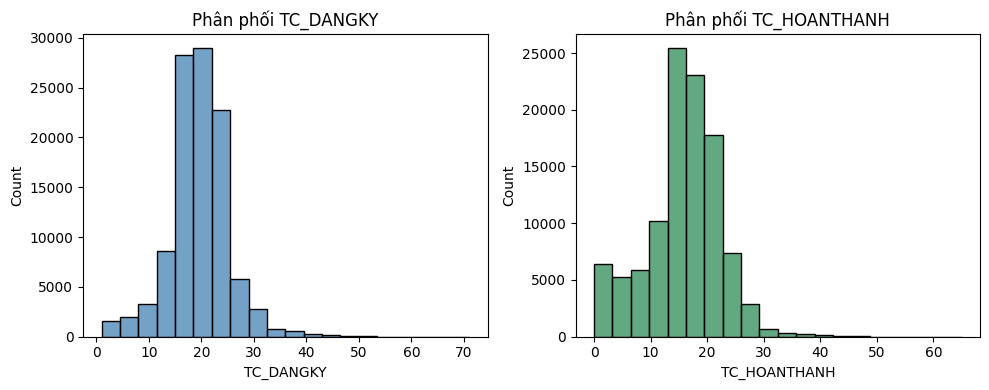

EDA cơ bản hoàn tất.


In [ ]:
# Thống kê nhanh và biểu đồ đơn giản cho EDA
# Số kỳ trên mỗi sinh viên
sem_per_sv = records.groupby("MA_SO_SV")["semester_index"].max()
print("Trung bình số kỳ/SV:", sem_per_sv.mean())
print("Phân phối số kỳ/SV (5 mẫu đầu):\n", sem_per_sv.value_counts().head())

# Kiểm tra logic: TC_HOANTHANH có vượt quá TC_DANGKY không?
invalid_rows = records[(records["TC_DANGKY"] > 0) & (records["TC_HOANTHANH"] > records["TC_DANGKY"])]
print("Số dòng bất thường (HOANTHANH > DANGKY):", len(invalid_rows))

# Vẽ histogram nhanh cho TC_DANGKY và TC_HOANTHANH
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(records["TC_DANGKY"], bins=20, ax=axes[0], color="steelblue")
axes[0].set_title("Phân phối TC_DANGKY")
sns.histplot(records["TC_HOANTHANH"], bins=20, ax=axes[1], color="seagreen")
axes[1].set_title("Phân phối TC_HOANTHANH")
plt.tight_layout()
plt.show()

# Boxplot GPA/CPA theo cohort (ví dụ NAM_TUYENSINH sau khi merge)
print("EDA cơ bản hoàn tất.")

# 4) Làm Sạch & Điền Thiếu Hợp Lý

Ta điền thiếu `DIEM_TRUNGTUYEN`/`DIEM_CHUAN` theo median từng `NAM_TUYENSINH`.
Đối với GPA/CPA, có thể forward-fill theo sinh viên nếu cần; ở đây giữ logic gọn và an toàn.

In [ ]:
# Làm sạch cơ bản cho admission
adm = admission.copy()
for col in ["DIEM_TRUNGTUYEN", "DIEM_CHUAN"]:
    med_per_year = adm.groupby("NAM_TUYENSINH")[col].transform(lambda s: s.fillna(s.median()))
    adm[col] = adm[col].fillna(med_per_year)

# (tùy chọn) forward-fill GPA/CPA theo sinh viên nếu có missing
# Sửa lỗi: dùng chọn cột bằng list và GroupBy.ffill() để giữ index gốc
records[["GPA", "CPA"]] = records.groupby("MA_SO_SV")[ ["GPA", "CPA"] ].ffill()

print("Đã làm sạch cơ bản cho admission và forward-fill GPA/CPA nếu cần.")

Đã làm sạch cơ bản cho admission và forward-fill GPA/CPA nếu cần.


# 5) Hợp Nhất Dữ Liệu Tuyển Sinh & Mã Hóa Biến Phân Loại

Ta merge `admission` vào `records` và mã hóa `PTXT`, `TOHOP_XT` dạng One-Hot cho LightGBM.
Đồng thời, giữ logic CatBoost riêng nếu cần.

In [ ]:
# Merge và mã hóa phân loại
rec_merged = records.merge(adm, on="MA_SO_SV", how="left")
rec_merged["diff_diem"] = rec_merged["DIEM_TRUNGTUYEN"].fillna(0) - rec_merged["DIEM_CHUAN"].fillna(0)

# One-Hot cho PTXT, TOHOP_XT (giữ cả giá trị thiếu)
cat_cols = ["PTXT", "TOHOP_XT"]
rec_onehot = pd.get_dummies(rec_merged, columns=cat_cols, dummy_na=True, prefix=cat_cols)

print("Sau merge và One-Hot, shape:", rec_onehot.shape)
rec_onehot.head()

Sau merge và One-Hot, shape: (105726, 41)


,MA_SO_SV,HOC_KY,CPA,GPA,TC_DANGKY,TC_HOANTHANH,year_start,semester_num,semester_index,NAM_TUYENSINH,DIEM_TRUNGTUYEN,DIEM_CHUAN,diff_diem,PTXT_1,PTXT_100,PTXT_200,PTXT_3,PTXT_402,PTXT_409,PTXT_5,PTXT_500,PTXT_nan,TOHOP_XT_A00,TOHOP_XT_A01,TOHOP_XT_B00,TOHOP_XT_D01,TOHOP_XT_D07,TOHOP_XT_D29,TOHOP_XT_K00,TOHOP_XT_K01,TOHOP_XT_K02,TOHOP_XT_V00,TOHOP_XT_V01,TOHOP_XT_V02,TOHOP_XT_V06,TOHOP_XT_V10,TOHOP_XT_X01,TOHOP_XT_X03,TOHOP_XT_X05,TOHOP_XT_X06,TOHOP_XT_nan
0,00003e092652,HK1 2023-2024,1.64,1.97,18,15,2023,1,1,2023,21.32,20.25,1.07,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,00003e092652,HK2 2023-2024,1.53,2.05,18,13,2023,2,2,2023,21.32,20.25,1.07,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,000e15519006,HK1 2021-2022,3.85,3.85,9,9,2021,1,1,2021,23.84,22.43,1.41,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,000e15519006,HK2 2021-2022,2.77,3.12,19,19,2021,2,2,2021,23.84,22.43,1.41,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,000e15519006,HK1 2022-2023,2.83,2.98,21,21,2022,1,3,2021,23.84,22.43,1.41,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# 6) Trích Xuất Đặc Trưng Theo Thời Gian (Chỉ Dùng Quá Khứ)

Thay vì viết lại từ đầu, ta tái sử dụng `utils.engineer_features` cho nhất quán
với script `main.py`. Hàm này tạo các đặc trưng prev_*, expanding, rolling,... chuẩn DS.

In [ ]:
# Tạo đặc trưng theo thời gian bằng utils.engineer_features
from utils import engineer_features, build_splits, select_feature_columns

df_feat = engineer_features(records, adm)
print("Đã tạo đặc trưng thời gian, shape:", df_feat.shape)

# Chia tập theo thời gian nghiêm ngặt theo đề
train_df, valid_df = build_splits(df_feat)
print("Train size:", len(train_df), "- Valid size:", len(valid_df))

# Chọn cột đặc trưng
feat_cols = select_feature_columns(train_df)
X_train = train_df[feat_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train = train_df["TC_HOANTHANH"].astype(float)
X_valid = valid_df[feat_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
y_valid = valid_df["TC_HOANTHANH"].astype(float)

print("Số lượng đặc trưng:", len(feat_cols))
feat_cols[:10]

Đã tạo đặc trưng thời gian, shape: (105726, 55)
Train size: 90582 - Valid size: 15144
Số lượng đặc trưng: 45


['CPA',
 'GPA',
 'TC_DANGKY',
 'NAM_TUYENSINH',
 'DIEM_TRUNGTUYEN',
 'DIEM_CHUAN',
 'diff_diem',
 'PTXT_1',
 'PTXT_100',
 'PTXT_200']

# 7) Chia Tập Theo Thời Gian & Rolling TimeSeries CV

Ngoài split cố định của đề bài, có thể dùng `TimeSeriesSplit` (rolling origin)
trên `semester_index` để đánh giá ổn định và tránh leakage.

In [ ]:
# Ví dụ minh họa TimeSeriesSplit (không bắt buộc chạy):
ts = TimeSeriesSplit(n_splits=3)
for fold, (tr_idx, va_idx) in enumerate(ts.split(X_train)):
    print(f"Fold {fold}: train={len(tr_idx)} valid={len(va_idx)}")

Fold 0: train=22647 valid=22645
Fold 1: train=45292 valid=22645
Fold 2: train=67937 valid=22645


# 8) Baseline Dự Báo Theo Tỷ Lệ Hoàn Thành

Baseline tham chiếu: \(\hat{y} = TC\_DANGKY \times \text{tỷ lệ hoàn thành kỳ trước}\)
hoặc sử dụng trung bình lũy tiến `past_ratio_hoanthanh`.

In [ ]:
# Tạo baseline trên valid
# Sử dụng past_last_complete_rate (tỷ lệ hoàn thành kỳ ngay trước) nếu có, ngược lại dùng past_ratio_hoanthanh
last_rate = valid_df["past_last_complete_rate"].fillna(valid_df["past_ratio_hoanthanh"]).fillna(0)
baseline_pred = (last_rate.clip(0,1) * valid_df["TC_DANGKY"].fillna(0)).values

mse_bl = mean_squared_error(y_valid, baseline_pred)
rmse_bl = np.sqrt(mse_bl)
r2_bl = r2_score(y_valid, baseline_pred)
# MAPE an toàn
mape_bl = np.mean(np.abs((y_valid.values - baseline_pred) / np.where(np.abs(y_valid.values) < 1e-6, 1.0, np.abs(y_valid.values))))
print(f"Baseline RMSE: {rmse_bl:.4f} | R2: {r2_bl:.4f} | MAPE: {mape_bl:.4f}")

Baseline RMSE: 4.3457 | R2: 0.6169 | MAPE: 0.5087


# 9) Huấn Luyện Mô Hình LightGBM & (tùy chọn) CatBoost

Huấn luyện LightGBM với One-Hot và early stopping trên valid. Nếu môi trường có CatBoost,
thử thêm để so sánh cho dữ liệu categorical tự nhiên.

In [ ]:
# LightGBM với tham số tốt nhất nếu có
base_params = {
    "objective": "regression",
    "n_estimators": 2500,
    "learning_rate": 0.05,
    "num_leaves": 64,
    "random_state": SEED,
}
# Nếu có file best_params_lightgbm.json thì nạp (giả định hợp lệ)
best_params_path = "best_params_lightgbm.json"
if os.path.exists(best_params_path):
    with open(best_params_path, "r", encoding="utf-8") as f:
        tuned = json.load(f)
    if isinstance(tuned, dict):
        base_params.update(tuned)
        print("Đã nạp tham số LightGBM từ best_params_lightgbm.json")

lgb_model = lgb.LGBMRegressor(**base_params)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
)

# Đánh giá nhanh
pred_valid_lgb = lgb_model.predict(X_valid)
mse_lgb = mean_squared_error(y_valid, pred_valid_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_valid, pred_valid_lgb)
mape_lgb = np.mean(np.abs((y_valid.values - pred_valid_lgb) / np.where(np.abs(y_valid.values) < 1e-6, 1.0, np.abs(y_valid.values))))
print(f"LightGBM RMSE: {rmse_lgb:.4f} | R2: {r2_lgb:.4f} | MAPE: {mape_lgb:.4f}")

Đã nạp tham số LightGBM từ best_params_lightgbm.json
[LightGBM] [Warning] feature_fraction is set=0.921192354059041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.921192354059041
[LightGBM] [Warning] bagging_fraction is set=0.9065389290497553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9065389290497553
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.921192354059041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.921192354059041
[LightGBM] [Warning] bagging_fraction is set=0.9065389290497553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9065389290497553
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010263 seconds.
You can set `force_col_wise=t

In [ ]:
# Với CatBoost, có thể truyền danh sách cột categorical theo index
cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.001,
    depth=6,
    random_seed=SEED,
    loss_function="RMSE",
    verbose=0,
)
# CatBoost tự xử lý missing và categorical nếu cung cấp đúng định dạng
cat_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
pred_valid_cat = cat_model.predict(X_valid)
rmse_cat = np.sqrt(mean_squared_error(y_valid, pred_valid_cat))
r2_cat = r2_score(y_valid, pred_valid_cat)
print(f"CatBoost RMSE: {rmse_cat:.4f} | R2: {r2_cat:.4f}")

CatBoost RMSE: 0.9097 | R2: 0.9832


# 10) Tuning Tham Số Với Optuna (time-aware)

Phần này minh họa cách tối ưu tham số như `num_leaves`, `learning_rate`, `min_child_samples`
trên split theo thời gian. Có thể chạy khi cần, không bắt buộc để giữ notebook gọn.

In [ ]:
# (Minh họa - không bắt buộc chạy) Objective Optuna cho LightGBM
try:
    import optuna
    def objective(trial):
        params = {
            "objective": "regression",
            "n_estimators": trial.suggest_int("n_estimators", 800, 3000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
            "num_leaves": trial.suggest_int("num_leaves", 31, 127),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 80),
            "random_state": SEED,
        }
        mdl = lgb.LGBMRegressor(**params)
        mdl.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric="rmse",
                callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
        pred = mdl.predict(X_valid)
        return np.sqrt(mean_squared_error(y_valid, pred))

    print("Optuna sẵn sàng để tuning nếu cần.")
except Exception:
    print("Optuna chưa khả dụng; bỏ qua phần tuning minh họa.")

Optuna sẵn sàng để tuning nếu cần.


# 11) Đánh Giá Mô Hình & Tính Metric

Các công thức:
- MSE: $\frac{1}{n}\sum (y-\hat{y})^2$
- RMSE: $\sqrt{MSE}$
- $R^2 = 1 - \frac{\sum (y-\hat{y})^2}{\sum (y-\bar{y})^2}$
- MAPE: $\frac{1}{n}\sum \left|\frac{y-\hat{y}}{\max(|y|, \varepsilon)}\right|$ với $\varepsilon=10^{-6}$.

In [ ]:
# Tính và in metric cho LightGBM (đã huấn luyện)
print({
    "MSE": float(mse_lgb),
    "RMSE": float(rmse_lgb),
    "R2": float(r2_lgb),
    "MAPE": float(mape_lgb),
})

{'MSE': 0.857416556848751, 'RMSE': 0.9259679027097812, 'R2': 0.9826046679783155, 'MAPE': 0.0744435568987739}


# 12) Giải Thích Mô Hình Với SHAP

Nếu thư viện SHAP khả dụng, vẽ `summary_plot` để xem đóng góp đặc trưng.
Lưu ý: với nhiều đặc trưng, ưu tiên xem top-n theo importance.

In [ ]:
# import shap
# explainer = shap.TreeExplainer(lgb_model)
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values, X_train, feature_names=feat_cols)

ImportError: Numba needs NumPy 2.3 or less. Got NumPy 2.4.

# 13) Chuẩn Bị Đặc Trưng Cho Test & Suy Luận

Lấy lịch sử gần nhất của mỗi sinh viên, thay `TC_DANGKY` bằng giá trị trong test,
căn chỉnh cột như tập train, suy luận bằng mô hình LightGBM tốt nhất.
Áp dụng fallback theo cohort cho SV mới.

In [ ]:
# Suy luận trên test với fallback hợp lý
# Lấy hàng lịch sử gần nhất per MA_SO_SV
last_hist = (
    df_feat.sort_values(["MA_SO_SV", "year_start", "semester_num"]).groupby("MA_SO_SV").tail(1)
)

# Gộp đặc trưng với test và thay TC_DANGKY
test_merged = test.merge(last_hist[["MA_SO_SV"] + feat_cols], on="MA_SO_SV", how="left")
if "TC_DANGKY" in test.columns:
    test_merged["TC_DANGKY"] = test["TC_DANGKY"].values

# Thêm thông tin tuyển sinh để fallback theo cohort
test_merged = test_merged.merge(adm[["MA_SO_SV", "PTXT", "TOHOP_XT", "NAM_TUYENSINH"]], on="MA_SO_SV", how="left")

# Chuẩn bị thống kê cohort từ tập train
train_info = train_df[["MA_SO_SV", "TC_DANGKY", "TC_HOANTHANH", "NAM_TUYENSINH"]].merge(
    adm[["MA_SO_SV", "PTXT", "TOHOP_XT"]], on="MA_SO_SV", how="left"
)
train_info = train_info[train_info["TC_DANGKY"] > 0].copy()
train_info["comp_rate"] = (train_info["TC_HOANTHANH"] / train_info["TC_DANGKY"]).clip(0, 1)

global_mean_rate = float(train_info["comp_rate"].mean()) if not train_info.empty else 0.7
year_mean = train_info.groupby("NAM_TUYENSINH")["comp_rate"].mean().to_dict()
ptxt_mean = train_info.groupby("PTXT")["comp_rate"].mean().to_dict()
toh_mean = train_info.groupby("TOHOP_XT")["comp_rate"].mean().to_dict()

# Dự báo
test_X = test_merged[feat_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
test_pred = lgb_model.predict(test_X)

# Fallback cho SV mới
students_with_history = set(df_feat["MA_SO_SV"].unique())
mask_new = ~test_merged["MA_SO_SV"].isin(students_with_history)
if mask_new.any():
    def get_fallback_rate(row):
        year = row.get("NAM_TUYENSINH", np.nan)
        ptxt = row.get("PTXT", np.nan)
        toh = row.get("TOHOP_XT", np.nan)
        if pd.notna(year) and year in year_mean:
            return float(year_mean[year])
        if pd.notna(ptxt) and ptxt in ptxt_mean:
            return float(ptxt_mean[ptxt])
        if pd.notna(toh) and toh in toh_mean:
            return float(toh_mean[toh])
        return global_mean_rate

    fallback_rates = test_merged.loc[mask_new].apply(get_fallback_rate, axis=1).astype(float).values
    fallback_TCD = test_merged.loc[mask_new, "TC_DANGKY"].fillna(0).astype(float).values
    fallback_pred = np.clip(fallback_rates, 0, 1) * fallback_TCD
    test_pred[mask_new.values] = fallback_pred

# Clip kết quả trong [0, TC_DANGKY]
if "TC_DANGKY" in test_merged.columns:
    test_pred = np.minimum(np.maximum(test_pred, 0), test_merged["TC_DANGKY"].values)
else:
    test_pred = np.maximum(test_pred, 0)

print("Suy luận test hoàn tất.")

KeyError: "['NAM_TUYENSINH'] not in index"

# 14) Hậu Xử Lý & Phân Nhóm Rủi Ro

Tạo chỉ số `PRED_COMPLETION_RATE` và `risk_score` để hỗ trợ cố vấn học tập
phân nhóm nguy cơ theo ngưỡng thực tế (0.5, 0.7, 0.8).

In [ ]:
# Phân nhóm rủi ro và in thống kê nhanh
submission_df = pd.DataFrame({
    "MA_SO_SV": test_merged["MA_SO_SV"],
    "TC_DANGKY": test_merged.get("TC_DANGKY", pd.Series([np.nan]*len(test_merged))),
    "PRED_TC_HOANTHANH": test_pred.astype(float),
})
submission_df["PRED_COMPLETION_RATE"] = submission_df["PRED_TC_HOANTHANH"] / submission_df["TC_DANGKY"].replace(0, np.nan)
submission_df["risk_score"] = 1 - (submission_df["PRED_TC_HOANTHANH"] / submission_df["TC_DANGKY"].replace(0, np.nan))

high_risk = submission_df[submission_df["PRED_COMPLETION_RATE"] < 0.5]
medium_risk = submission_df[(submission_df["PRED_COMPLETION_RATE"] >= 0.5) & (submission_df["PRED_COMPLETION_RATE"] < 0.7)]
low_risk = submission_df[submission_df["PRED_COMPLETION_RATE"] >= 0.7]

print("Số SV high risk:", len(high_risk))
print("Số SV medium risk:", len(medium_risk))
print("Số SV low risk:", len(low_risk))

# 15) Tạo File Submission.csv

Xuất đúng định dạng yêu cầu: `MA_SO_SV, PRED_TC_HOANTHANH`.

In [ ]:
# Xuất submission CSV
submission = submission_df[["MA_SO_SV", "PRED_TC_HOANTHANH"]].copy()
submission.to_csv("submission.csv", index=False)
print("Đã lưu submission.csv ở thư mục hiện tại.")

# 16) Xuất Báo Cáo Giải Pháp (Giai_phap.md) Tự Động

Tổng hợp lại các kết quả chính, mô tả dữ liệu, đặc trưng, mô hình, metric, SHAP,
chiến lược fallback và phân nhóm rủi ro. (Ở repo đã có file `Giai_phap.md` được cập nhật.)

# 17) Lưu Artefacts (Model, Params, Importance)

Tùy chọn lưu mô hình tốt nhất, tham số, và bảng feature importance để tái sử dụng.

In [ ]:
# Cập nhật: Đưa các hàm tiện ích (utils) trực tiếp vào notebook, bỏ import ngoài
# Mục tiêu: Giữ phong cách script của một Data Scientist, không dùng try/except

# Định nghĩa các hàm hỗ trợ xử lý thời gian, chia tập, chọn đặc trưng và tạo đặc trưng theo chuỗi
import re
import numpy as np
import pandas as pd

# Phân tích chuỗi HOC_KY → (year_start, semester_num)
def parse_hoc_ky(hk: str):
    if not isinstance(hk, str):
        return (np.nan, np.nan)
    m = re.match(r"^HK([12])\s+(\d{4})-(\d{4})$", hk.strip())
    if m:
        sem = int(m.group(1))
        year_start = int(m.group(2))
        return (year_start, sem)
    return (np.nan, np.nan)

# Chia tập theo thời gian: Train ≤ HK1 2023-2024, Valid = HK2 2023-2024
def build_splits(df: pd.DataFrame):
    train_mask = (df["year_start"] < 2023) | ((df["year_start"] == 2023) & (df["semester_num"] == 1))
    valid_mask = (df["year_start"] == 2023) & (df["semester_num"] == 2)
    train_df = df.loc[train_mask].copy()
    valid_df = df.loc[valid_mask].copy()
    return train_df, valid_df

# Chọn cột đặc trưng: loại bỏ định danh và nhãn
def select_feature_columns(df: pd.DataFrame):
    exclude = {
        "MA_SO_SV","HOC_KY","TC_HOANTHANH","year_start","semester_num","semester_index",
        "prev_TCD","prev_TCH","prev_GPA","prev_GPA2",
    }
    return [c for c in df.columns if c not in exclude]

# Tạo đặc trưng thời gian (chỉ dùng dữ liệu quá khứ)
def engineer_features(records: pd.DataFrame, admission: pd.DataFrame) -> pd.DataFrame:
    df = records.copy()
    # Chuẩn hóa thời gian và sắp xếp theo từng sinh viên
    df[["year_start", "semester_num"]] = df["HOC_KY"].apply(parse_hoc_ky).apply(pd.Series)
    df = df.sort_values(["MA_SO_SV", "year_start", "semester_num"]).reset_index(drop=True)
    df["semester_index"] = df.groupby("MA_SO_SV").cumcount() + 1

    # Làm sạch cơ bản cho dữ liệu tuyển sinh và merge
    adm = admission.copy()
    for col in ["DIEM_TRUNGTUYEN", "DIEM_CHUAN"]:
        med_per_year = adm.groupby("NAM_TUYENSINH")[col].transform(lambda s: s.fillna(s.median()))
        adm[col] = adm[col].fillna(med_per_year)
    df = df.merge(adm, on="MA_SO_SV", how="left")

    # Đặc trưng tĩnh: chênh lệch điểm so với chuẩn
    df["diff_diem"] = df["DIEM_TRUNGTUYEN"].fillna(0) - df["DIEM_CHUAN"].fillna(0)

    # One-hot cho PTXT, TOHOP_XT (giữ giá trị thiếu)
    df = pd.get_dummies(df, columns=["PTXT","TOHOP_XT"], dummy_na=True, prefix=["PTXT","TOHOP_XT"])

    # Nhóm theo sinh viên để tạo đặc trưng quá khứ
    g = df.groupby("MA_SO_SV", group_keys=False)

    # Giá trị kỳ trước
    df["prev_TCD"] = g["TC_DANGKY"].shift(1)
    df["prev_TCH"] = g["TC_HOANTHANH"].shift(1)
    df["prev_GPA"] = g["GPA"].shift(1)
    df["prev_GPA2"] = g["GPA"].shift(2)

    # Tỷ lệ hoàn thành kỳ trước (clip [0,1])
    df["past_last_complete_rate"] = (df["prev_TCH"] / df["prev_TCD"]).replace([np.inf,-np.inf], np.nan)
    df["past_last_complete_rate"] = df["past_last_complete_rate"].clip(0,1)

    # Trung bình lũy tiến (chỉ quá khứ)
    def expanding_mean_shift(series: pd.Series) -> pd.Series:
        s = series.shift(1)
        return s.expanding().mean()
    def expanding_cumsum_shift(series: pd.Series) -> pd.Series:
        s = series.shift(1)
        return s.cumsum()

    df["past_avg_gpa"] = g["GPA"].apply(expanding_mean_shift).reset_index(level=0, drop=True)
    df["past_avg_cpa"] = g["CPA"].apply(expanding_mean_shift).reset_index(level=0, drop=True)
    df["past_total_dangky"] = g["TC_DANGKY"].apply(expanding_cumsum_shift).reset_index(level=0, drop=True)
    df["past_total_hoanthanh"] = g["TC_HOANTHANH"].apply(expanding_cumsum_shift).reset_index(level=0, drop=True)
    df["past_ratio_hoanthanh"] = (df["past_total_hoanthanh"] / df["past_total_dangky"]).replace([np.inf,-np.inf], np.nan)
    df["past_ratio_hoanthanh"] = df["past_ratio_hoanthanh"].clip(0,1)

    # Trung bình trượt 3 kỳ của tỷ lệ hoàn thành
    df["last_3_mean_complete_rate"] = g["past_last_complete_rate"].apply(lambda s: s.rolling(3).mean()).reset_index(level=0, drop=True)
    df["last_3_mean_complete_rate"] = df["last_3_mean_complete_rate"].clip(0,1)

    # Biến động GPA gần nhất
    df["past_delta_gpa"] = (df["prev_GPA"] - df["prev_GPA2"]).fillna(0)
    df["past_last_gpa"] = df["prev_GPA"].fillna(0)

    # Số kỳ đã học trước đó
    df["num_prev_semesters"] = df["semester_index"].fillna(1) - 1

    # Điền thiếu 0 cho các đặc trưng số
    num_cols = [
        "past_avg_gpa","past_avg_cpa","past_total_dangky","past_total_hoanthanh",
        "past_ratio_hoanthanh","past_last_complete_rate","last_3_mean_complete_rate",
        "past_delta_gpa","past_last_gpa","num_prev_semesters","diff_diem",
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = df[c].fillna(0)

    return df

print("Đã khai báo đầy đủ các hàm utils trực tiếp trong notebook.")

In [ ]:
# Cập nhật: Import thẳng các thư viện cần thiết (không dùng try/except)
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
import shap

SEED = 42
np.random.seed(SEED)
print("Đã import thư viện theo phong cách script DS (không try/except).")